# About this notebook

This notebook calculates a spectrum for a single photon energy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc

# Multiprocessing
import multiprocessing as mp
from multiprocessing import Pool

# For the progress bar
from ipywidgets import IntProgress
from IPython.display import display

# This package
import XNLdyn

%matplotlib notebook

import warnings
warnings.filterwarnings('default')

In [21]:

pulse_energy_max = 5e-9 # Joule

## Set up the problem and modify the parameters a little
PAR = XNLdyn.XNLpars()
PAR.N_photens = 1
PAR.t0_i       = [0,]   # Arrival time on time-axis / fs
#PAR.tdur_sig_i = [13,]  # Rms pulse duration / fs
PAR.E_i_abs    = [844.76,] # Photon Energies of incident pulses / eV
PAR.lambda_res_Ei = (270,)
PAR.pendepth_nonres = (940,)


PAR.I0_i =  [XNLdyn.photons_per_J(PAR.E_i_abs[0])*pulse_energy_max]

#* XNLdyn.photons_per_J(PAR.E_i_abs[0])




In [22]:
pulse_energy_max_photons = pulse_energy_max *  XNLdyn.photons_per_J(PAR.E_i_abs[0])
pulse_energy_max_photons/PAR.atomic_density

404184.8895166606

In [23]:
sim = XNLdyn.XNLsim(PAR, DEBUG=True)
#PAR.FermiSolver.plot_lookup_tables(), load_tables = False

<IPython.core.display.Javascript object>


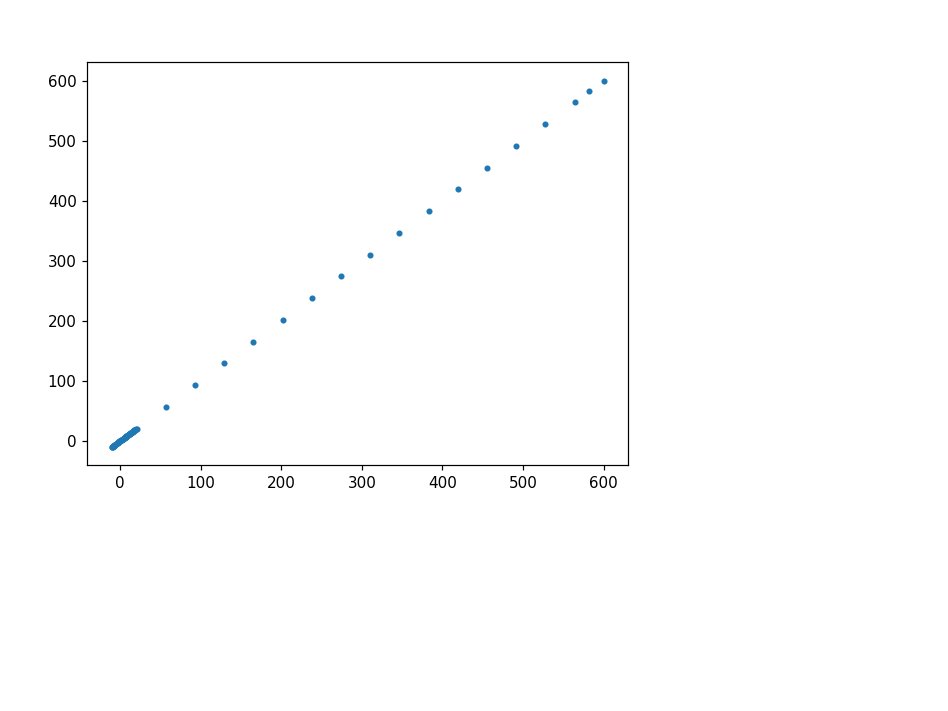

In [24]:
plt.figure()
plt.plot(sim.par.E_j,sim.par.E_j,'.')

<IPython.core.display.Javascript object>


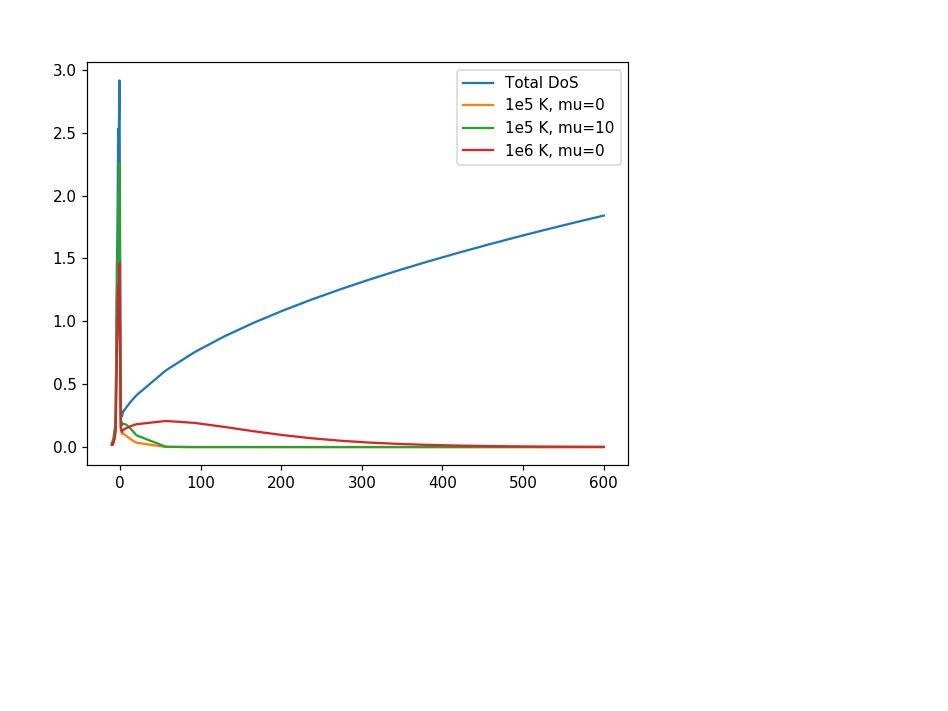

In [25]:
plt.figure()
plt.plot(PAR.E_j,PAR.m_j/PAR.enax_dE_j, label ='Total DoS')
plt.plot(PAR.E_j,PAR.FermiSolver.fermi(1e5*PAR.kB,0)*PAR.m_j/PAR.enax_dE_j, label = '1e5 K, mu=0')
plt.plot(PAR.E_j,PAR.FermiSolver.fermi(1e5*PAR.kB,10)*PAR.m_j/PAR.enax_dE_j, label = '1e5 K, mu=10')
plt.plot(PAR.E_j,PAR.FermiSolver.fermi(1e6*PAR.kB,0)*PAR.m_j/PAR.enax_dE_j, label = '1e6 K, mu=0')
plt.legend()

# Determine Fluences to calculate

In [26]:
%%time

N_local_fluences_to_calculate = 30
N_pulse_energies = 20

Nsteps_r = 100

pulse_profile_sigma= 400 # nm rms

fluences_joules_nm2, dA = XNLdyn.calculate_fluences(Nsteps_r, pulse_energy_max, pulse_profile_sigma) 

fluences_simulated_joules_nm2 = np.logspace(np.log10(np.min(fluences_joules_nm2*1e-2)),
                                 np.log10(np.max(fluences_joules_nm2)),
                                 N_local_fluences_to_calculate)

fluences_simulated_joules_cm2 = fluences_simulated_joules_nm2 * 1e14
fluences_simulated_photons_nm2_rough = fluences_simulated_joules_nm2 * XNLdyn.photons_per_J(850)

CPU times: user 187 µs, sys: 143 µs, total: 330 µs
Wall time: 311 µs


## Run a simulation for a single Fluence

Simulating for  0.009354989665559702 photons per atom
Initializing a simulation where ['I0_i'] are changed to [230.86243496668234]

t:  -42.0
-23.390398540400604 10.000492555796558 -> 300.0 0.0
Photons impinging per atom this timestep:  [0.03835] i.e.  [0.00041958] /atom
t:  -41.99975476307141
-23.390398539133855 10.000492555254965 -> 299.5834979708849 0.0002819886833935201
Photons impinging per atom this timestep:  [0.03835234] i.e.  [0.00041961] /atom
t:  -41.99509526142812
-23.390398515065712 10.000492544964704 -> 299.5991663769125 0.0002711000052898068
Photons impinging per atom this timestep:  [0.03839677] i.e.  [0.0004201] /atom
t:  -41.99264289214218
-23.390398501115197 10.000492539535411 -> 299.60027572260225 0.000270237303223206
Photons impinging per atom this timestep:  [0.03842018] i.e.  [0.00042035] /atom
t:  -41.98038104571247
-23.390398429913105 10.000492512374016 -> 299.55707696192957 0.0002989017916743846
Photons impinging per atom this timestep:  [0.03853739] i.e.  [0.

-23.389574930193525 10.000473866520208 -> 636.8097430084206 -0.16621221912447512
Photons impinging per atom this timestep:  [0.11731109] i.e.  [0.00128349] /atom
t:  -37.13023937854648
-23.389533989556718 10.000473237690294 -> 640.4349406306355 -0.16648151968057157
Photons impinging per atom this timestep:  [0.11992055] i.e.  [0.00131204] /atom
t:  -37.08023937854648
-23.38951198980843 10.000472908138665 -> 642.3380813860463 -0.16661621021831569
Photons impinging per atom this timestep:  [0.12124427] i.e.  [0.00132652] /atom
t:  -36.83023937854648
-23.389399720421746 10.000471242289986 -> 651.6097142981668 -0.16721243181749196
Photons impinging per atom this timestep:  [0.12805691] i.e.  [0.00140106] /atom
t:  -36.785794934102036
-23.389378305995866 10.000470937502296 -> 653.3018258146167 -0.16731097553172516
Photons impinging per atom this timestep:  [0.12930252] i.e.  [0.00141469] /atom
t:  -36.73023937854648
-23.38935187111102 10.000470551552048 -> 655.3596142147729 -0.1674270821771

Photons impinging per atom this timestep:  [0.27542473] i.e.  [0.0030134] /atom
t:  -33.08023937854648
-23.386286771753728 10.000432748388613 -> 798.5947875337142 -0.16952625657418408
Photons impinging per atom this timestep:  [0.27813561] i.e.  [0.00304306] /atom
t:  -32.83023937854648
-23.385952005831577 10.00042903088252 -> 809.1814521307805 -0.16943560030090113
Photons impinging per atom this timestep:  [0.29203077] i.e.  [0.00319509] /atom
t:  -32.785794934102036
-23.38588935038766 10.000428352585903 -> 811.1075299815337 -0.16941721533351406
Photons impinging per atom this timestep:  [0.29456132] i.e.  [0.00322277] /atom
t:  -32.73023937854648
-23.385811631424946 10.000427494758165 -> 813.4737289167723 -0.16939401209373256
Photons impinging per atom this timestep:  [0.29775046] i.e.  [0.00325766] /atom
t:  -32.73023937854648
-23.385813165007555 10.000427492839814 -> 813.427176133371 -0.16939458641832744
Photons impinging per atom this timestep:  [0.29775046] i.e.  [0.00325766] /at

-23.377038649150172 10.000339506832074 -> 999.1372062505001 -0.16607997734815463
Photons impinging per atom this timestep:  [0.60581156] i.e.  [0.00662814] /atom
t:  -28.785794934102036
-23.376889069768882 10.000338123764193 -> 1001.5531437851379 -0.16602520699217807
Photons impinging per atom this timestep:  [0.61041866] i.e.  [0.00667854] /atom
t:  -28.73023937854648
-23.37670298454058 10.000336377111633 -> 1004.5384720010516 -0.16595735308960124
Photons impinging per atom this timestep:  [0.61621671] i.e.  [0.00674198] /atom
t:  -28.73023937854648
-23.37670576841159 10.00033637370362 -> 1004.4938832322157 -0.16595844248047742
Photons impinging per atom this timestep:  [0.61621671] i.e.  [0.00674198] /atom
t:  -28.630239378546477
-23.37636854423978 10.000333215647391 -> 1009.8491560045633 -0.16583605499580778
Photons impinging per atom this timestep:  [0.62676349] i.e.  [0.00685737] /atom
t:  -28.58023937854648
-23.376192290093954 10.000331577177072 -> 1012.6206063030376 -0.165772364

-23.356812100251968 10.000163565009515 -> 1251.8827521596936 -0.1596668979131533
Photons impinging per atom this timestep:  [1.15070303] i.e.  [0.01258975] /atom
t:  -24.73023937854648
-23.356416984322923 10.000160327519826 -> 1255.9609197284065 -0.15955494787780575
Photons impinging per atom this timestep:  [1.16010651] i.e.  [0.01269263] /atom
t:  -24.73023937854648
-23.35642147042106 10.000160322133874 -> 1255.9146428719182 -0.1595562738937584
Photons impinging per atom this timestep:  [1.16010651] i.e.  [0.01269263] /atom
t:  -24.630239378546477
-23.355706159332872 10.000154472338307 -> 1263.2484123565257 -0.15935442127145036
Photons impinging per atom this timestep:  [1.17717265] i.e.  [0.01287935] /atom
t:  -24.58023937854648
-23.355334385872084 10.000151453340234 -> 1267.0354605239959 -0.15924989987296417
Photons impinging per atom this timestep:  [1.18577333] i.e.  [0.01297345] /atom
t:  -24.33023937854648
-23.35345629273175 10.000136251056862 -> 1285.9222770844458 -0.158725956

t:  -20.630239378546477
-23.31431236709935 9.99984113781035 -> 1625.62924267681 -0.14860083958070158
Photons impinging per atom this timestep:  [2.01122196] i.e.  [0.02200462] /atom
t:  -20.58023937854648
-23.31359974131909 9.999836088918112 -> 1631.2603480326763 -0.14842229949221247
Photons impinging per atom this timestep:  [2.02352027] i.e.  [0.02213917] /atom
t:  -20.33023937854648
-23.31000539606047 9.99981069802182 -> 1659.4923459535617 -0.14752204190298907
Photons impinging per atom this timestep:  [2.08568623] i.e.  [0.02281932] /atom
t:  -20.285794934102036
-23.30934771874417 9.999806111901696 -> 1664.6290948136011 -0.14735728616112956
Photons impinging per atom this timestep:  [2.09685506] i.e.  [0.02294152] /atom
t:  -20.23023937854648
-23.308525979444386 9.999800338497922 -> 1671.0352155985129 -0.14715145587490097
Photons impinging per atom this timestep:  [2.11086554] i.e.  [0.02309481] /atom
t:  -20.23023937854648
-23.30853255631424 9.999800330754635 -> 1670.9839104557136

-23.230972242970044 9.99929664519806 -> 2247.60440974585 -0.1267681355965374
Photons impinging per atom this timestep:  [3.21861052] i.e.  [0.03521456] /atom
t:  -16.285794934102036
-23.229824614111177 9.999289730283484 -> 2255.9998900046135 -0.12644356594696293
Photons impinging per atom this timestep:  [3.23244401] i.e.  [0.03536591] /atom
t:  -16.23023937854648
-23.228388653176463 9.999281038540067 -> 2266.505542964197 -0.1260363032541818
Photons impinging per atom this timestep:  [3.24976611] i.e.  [0.03555543] /atom
t:  -16.23023937854648
-23.228396556560014 9.999281029379278 -> 2266.4476279087735 -0.12603858346171312
Photons impinging per atom this timestep:  [3.24976611] i.e.  [0.03555543] /atom
t:  -16.130239378546477
-23.22580145975265 9.9992653465699 -> 2285.436936111802 -0.12529923412415675
Photons impinging per atom this timestep:  [3.28102913] i.e.  [0.03589747] /atom
t:  -16.08023937854648
-23.224466286352197 9.999257346801302 -> 2295.2089494497636 -0.12491711095721213
Ph

Photons impinging per atom this timestep:  [4.55121134] i.e.  [0.04979443] /atom
t:  -12.230239378546479
-23.094643851317766 9.998540383444997 -> 3258.9404695045664 -0.08173536235952135
Photons impinging per atom this timestep:  [4.55121134] i.e.  [0.04979443] /atom
t:  -12.130239378546479
-23.090471711777315 9.99851906077407 -> 3290.2535750564007 -0.08014997955193189
Photons impinging per atom this timestep:  [4.58413152] i.e.  [0.05015461] /atom
t:  -12.080239378546478
-23.088334636010444 9.998508246246404 -> 3306.2945605010623 -0.07933341181565778
Photons impinging per atom this timestep:  [4.6005787] i.e.  [0.05033456] /atom
t:  -11.830239378546478
-23.077586852813415 9.998454011527345 -> 3386.972387338136 -0.07518182202535145
Photons impinging per atom this timestep:  [4.68266488] i.e.  [0.05123266] /atom
t:  -11.785794934102034
-23.075640691517105 9.998444287749376 -> 3401.5805193962633 -0.07442212624793641
Photons impinging per atom this timestep:  [4.6972287] i.e.  [0.051392] /

Photons impinging per atom this timestep:  [5.84021522] i.e.  [0.06389732] /atom
t:  -7.830239378546478
-22.86335997484952 9.99748123071737 -> 4962.721161469844 0.01980964134100742
Photons impinging per atom this timestep:  [5.90934948] i.e.  [0.06465371] /atom
t:  -7.785794934102034
-22.86049687485748 9.99746945261781 -> 4983.111798522898 0.021196234229859466
Photons impinging per atom this timestep:  [5.92149615] i.e.  [0.06478661] /atom
t:  -7.730239378546479
-22.856907859945384 9.997454698614138 -> 5008.6437164541785 0.02293749045580866
Photons impinging per atom this timestep:  [5.93661702] i.e.  [0.06495205] /atom
t:  -7.730239378546479
-22.85691340962659 9.997454692410805 -> 5008.604194849443 0.022934774686735927
Photons impinging per atom this timestep:  [5.93661702] i.e.  [0.06495205] /atom
t:  -7.630239378546479
-22.850436794512735 9.997428111133 -> 5054.597851461593 0.026085564986648765
Photons impinging per atom this timestep:  [5.96365749] i.e.  [0.06524789] /atom
t:  -7.5

Photons impinging per atom this timestep:  [6.79054386] i.e.  [0.07429479] /atom
t:  -3.7302393785464787
-22.551187743004558 9.996337975999296 -> 7074.646427263404 0.17967871281169365
Photons impinging per atom this timestep:  [6.79893793] i.e.  [0.07438663] /atom
t:  -3.7302393785464787
-22.551189196929833 9.996337974514038 -> 7074.6370465979335 0.17967793786096384
Photons impinging per atom this timestep:  [6.79893793] i.e.  [0.07438663] /atom
t:  -3.6302393785464786
-22.542350047102776 9.996309224351473 -> 7131.496565404353 0.18435922056084716
Photons impinging per atom this timestep:  [6.81375981] i.e.  [0.07454879] /atom
t:  -3.580239378546479
-22.537862159133766 9.996294834242695 -> 7160.31156032019 0.18673777427508986
Photons impinging per atom this timestep:  [6.82103151] i.e.  [0.07462835] /atom
t:  -3.330239378546479
-22.515346288433793 9.996222881922236 -> 7304.328819395892 0.19868570006523126
Photons impinging per atom this timestep:  [6.85598511] i.e.  [0.07501078] /atom
t

Photons impinging per atom this timestep:  [7.08315071] i.e.  [0.07749618] /atom
t:  0.3697606214535213
-22.13803497629744 9.99517263322914 -> 9598.671253630988 0.3996183544657651
Photons impinging per atom this timestep:  [7.08181065] i.e.  [0.07748152] /atom
t:  0.41976062145352133
-22.13235066716908 9.995158950547536 -> 9631.713065004225 0.4026218580759289
Photons impinging per atom this timestep:  [7.0809836] i.e.  [0.07747247] /atom
t:  0.6697606214535213
-22.103859942453894 9.995090645246488 -> 9796.7111316581 0.4176529787407525
Photons impinging per atom this timestep:  [7.07527962] i.e.  [0.07741006] /atom
t:  0.7142050658979657
-22.098760216194243 9.995078552943822 -> 9826.138444036602 0.4203393858721969
Photons impinging per atom this timestep:  [7.07399217] i.e.  [0.07739598] /atom
t:  0.7697606214535213
-22.092365436873038 9.995063466223993 -> 9862.9933724761 0.42370618842880176
Photons impinging per atom this timestep:  [7.07226694] i.e.  [0.0773771] /atom
t:  0.7697606214

Photons impinging per atom this timestep:  [6.64202817] i.e.  [0.07266989] /atom
t:  4.714205065897966
-21.595695146611398 9.994081661646677 -> 12585.589648569581 0.6769968443353596
Photons impinging per atom this timestep:  [6.63383749] i.e.  [0.07258028] /atom
t:  4.769760621453521
-21.588138825768006 9.994069382228782 -> 12625.064604142657 0.680703556270641
Photons impinging per atom this timestep:  [6.62350448] i.e.  [0.07246723] /atom
t:  4.769760621453521
-21.588130037394738 9.994069392275009 -> 12625.110548738756 0.6807078908599918
Photons impinging per atom this timestep:  [6.62350448] i.e.  [0.07246723] /atom
t:  4.869760621453521
-21.574517031782854 9.994047333001276 -> 12696.090867574487 0.687373331153494
Photons impinging per atom this timestep:  [6.60464162] i.e.  [0.07226085] /atom
t:  4.919760621453522
-21.567658542462862 9.994036487707527 -> 12731.78712175496 0.6907257380790223
Photons impinging per atom this timestep:  [6.595084] i.e.  [0.07215628] /atom
t:  5.16976062

Photons impinging per atom this timestep:  [5.64287443] i.e.  [0.06173823] /atom
t:  8.869760621453521
-20.995479949362448 9.993316695743713 -> 15568.04971926021 0.9559197872706738
Photons impinging per atom this timestep:  [5.61350214] i.e.  [0.06141687] /atom
t:  8.919760621453522
-20.98786806978337 9.993309643868589 -> 15604.04426907203 0.9592540742044555
Photons impinging per atom this timestep:  [5.59874915] i.e.  [0.06125546] /atom
t:  9.169760621453522
-20.949779407408045 9.993274637911957 -> 15783.524558726283 0.9758621609037939
Photons impinging per atom this timestep:  [5.52433779] i.e.  [0.06044133] /atom
t:  9.214205065897966
-20.942996927847208 9.993268540919887 -> 15815.37541128622 0.9788063885978036
Photons impinging per atom this timestep:  [5.51099965] i.e.  [0.0602954] /atom
t:  9.269760621453521
-20.93449941581933 9.993260990448134 -> 15855.23387303796 0.9824895209356387
Photons impinging per atom this timestep:  [5.49428194] i.e.  [0.06011249] /atom
t:  9.2697606214

t:  13.169760621453522
-20.32066443010702 9.992892118209962 -> 18608.004563642357 1.232598833709269
Photons impinging per atom this timestep:  [4.24096294] i.e.  [0.04640003] /atom
t:  13.214205065897966
-20.31353188410861 9.992889724846087 -> 18638.625475315555 1.235327081219084
Photons impinging per atom this timestep:  [4.22627529] i.e.  [0.04623934] /atom
t:  13.269760621453521
-20.30460162365583 9.992886802767172 -> 18676.92292226345 1.2387374626941574
Photons impinging per atom this timestep:  [4.20791808] i.e.  [0.04603849] /atom
t:  13.269760621453521
-20.30458992932312 9.992886816046193 -> 18676.97307448783 1.2387419444889076
Photons impinging per atom this timestep:  [4.20791808] i.e.  [0.04603849] /atom
t:  13.369760621453521
-20.28851409586389 9.992881610713065 -> 18745.79863355943 1.244865568942689
Photons impinging per atom this timestep:  [4.17488366] i.e.  [0.04567706] /atom
t:  13.419760621453522
-20.280464231379767 9.992879236075966 -> 18780.207275993544 1.24792466756

-19.66643942704195 9.9928314245214 -> 21301.630930468396 1.4672524203032087
Photons impinging per atom this timestep:  [2.94827877] i.e.  [0.03225688] /atom
t:  17.26976062145352
-19.657450683736354 9.99283265022453 -> 21337.10868970021 1.4702668545091044
Photons impinging per atom this timestep:  [2.93161526] i.e.  [0.03207457] /atom
t:  17.26976062145352
-19.65744087032249 9.992832661223442 -> 21337.14741382527 1.4702701538838974
Photons impinging per atom this timestep:  [2.93161526] i.e.  [0.03207457] /atom
t:  17.369760621453523
-19.641263855895073 9.992834912096356 -> 21400.897437243842 1.4756814797600217
Photons impinging per atom this timestep:  [2.90172439] i.e.  [0.03174753] /atom
t:  17.41976062145352
-19.633181014638446 9.992836223873061 -> 21432.70271820292 1.478378843982329
Photons impinging per atom this timestep:  [2.88682937] i.e.  [0.03158457] /atom
t:  17.66976062145352
-19.592780082962292 9.992842976545731 -> 21591.203393068 1.4917956026872459
Photons impinging per 

Photons impinging per atom this timestep:  [1.85793294] i.e.  [0.02032749] /atom
t:  21.26976062145352
-19.017826400500834 9.993042140941863 -> 23765.029135571724 1.6714671292293992
Photons impinging per atom this timestep:  [1.85793294] i.e.  [0.02032749] /atom
t:  21.369760621453523
-19.00210136277184 9.993050016395017 -> 23822.423458600362 1.6760981596524358
Photons impinging per atom this timestep:  [1.83464188] i.e.  [0.02007267] /atom
t:  21.41976062145352
-18.994257775905304 9.993054081947449 -> 23851.01215802813 1.6784028107899471
Photons impinging per atom this timestep:  [1.82306562] i.e.  [0.01994601] /atom
t:  21.66976062145352
-18.95506567143776 9.993074539257316 -> 23993.469444521674 1.689864526283774
Photons impinging per atom this timestep:  [1.76587893] i.e.  [0.01932034] /atom
t:  21.714205065897964
-18.948114058373406 9.993078243126522 -> 24018.669541493557 1.691888230654977
Photons impinging per atom this timestep:  [1.75583387] i.e.  [0.01921044] /atom
t:  21.76976

t:  25.369760621453523
-18.38965308457579 9.993445858932725 -> 25978.658646302552 1.8456973840123017
Photons impinging per atom this timestep:  [1.05518792] i.e.  [0.01154473] /atom
t:  25.41976062145352
-18.38223530491937 9.993451629729293 -> 26003.864627055355 1.847628507036622
Photons impinging per atom this timestep:  [1.04728974] i.e.  [0.01145831] /atom
t:  25.66976062145352
-18.34517931513951 9.993480552611771 -> 26129.469466915616 1.857233241774263
Photons impinging per atom this timestep:  [1.00845305] i.e.  [0.0110334] /atom
t:  25.714205065897964
-18.338610122679114 9.993485730768226 -> 26151.68209192564 1.8589286552320878
Photons impinging per atom this timestep:  [1.0016623] i.e.  [0.01095911] /atom
t:  25.76976062145352
-18.330401915618562 9.993492223509197 -> 26179.413868137915 1.8610440023453871
Photons impinging per atom this timestep:  [0.99322181] i.e.  [0.01086676] /atom
t:  25.76976062145352
-18.330398269864684 9.993492227457281 -> 26179.42618028503 1.8610449424035

Photons impinging per atom this timestep:  [0.54728653] i.e.  [0.00598782] /atom
t:  29.66976062145352
-17.774332681455046 9.993982099167509 -> 28000.913441051776 1.996717535869701
Photons impinging per atom this timestep:  [0.5238824] i.e.  [0.00573175] /atom
t:  29.714205065897964
-17.76823463153102 9.993987955768999 -> 28020.28566327425 1.9981254023405959
Photons impinging per atom this timestep:  [0.51980757] i.e.  [0.00568717] /atom
t:  29.76976062145352
-17.7606184917725 9.993995283446544 -> 28044.462826740346 1.9998814171775599
Photons impinging per atom this timestep:  [0.51475011] i.e.  [0.00563184] /atom
t:  29.76976062145352
-17.760617138449028 9.993995284937732 -> 28044.467121084122 1.9998817292014253
Photons impinging per atom this timestep:  [0.51475011] i.e.  [0.00563184] /atom
t:  29.869760621453523
-17.74691602469923 9.994008479995552 -> 28087.911371951897 2.0030341793844446
Photons impinging per atom this timestep:  [0.5057471] i.e.  [0.00553334] /atom
t:  29.91976062

-17.2421738336921 9.99452364895982 -> 29645.57590471804 2.113553178075596
Photons impinging per atom this timestep:  [0.24538456] i.e.  [0.00268473] /atom
t:  33.76976062145352
-17.235187579899367 9.994531112330858 -> 29666.57130528169 2.1150091311626884
Photons impinging per atom this timestep:  [0.24267778] i.e.  [0.00265512] /atom
t:  33.76976062145352
-17.235187737501892 9.994531112238917 -> 29666.570831797104 2.115009098431959
Photons impinging per atom this timestep:  [0.24267778] i.e.  [0.00265512] /atom
t:  33.86976062145352
-17.22262034441842 9.994544544913307 -> 29704.301479287842 2.1176232884648285
Photons impinging per atom this timestep:  [0.23786966] i.e.  [0.00260251] /atom
t:  33.91976062145352
-17.216368600115544 9.994551255063397 -> 29723.052974227532 2.1189214316766334
Photons impinging per atom this timestep:  [0.23549622] i.e.  [0.00257655] /atom
t:  34.16976062145352
-17.185145143083624 9.994584796099433 -> 29816.527321950743 2.1253816859621235
Photons impinging p

t:  37.76976062145352
-16.754994923951575 9.99506004539479 -> 31075.149823714208 2.2106054446893504
Photons impinging per atom this timestep:  [0.10407513] i.e.  [0.00113868] /atom
t:  37.76976062145352
-16.754995912689292 9.995060044417844 -> 31075.14699102325 2.210605256775528
Photons impinging per atom this timestep:  [0.10407513] i.e.  [0.00113868] /atom
t:  37.86976062145352
-16.74354629665556 9.9950729709339 -> 31107.930840843368 2.212780926170037
Photons impinging per atom this timestep:  [0.10177194] i.e.  [0.00111348] /atom
t:  37.91976062145352
-16.737852204533947 9.99507941329718 -> 31124.221390233495 2.213861204838809
Photons impinging per atom this timestep:  [0.1006373] i.e.  [0.00110106] /atom
t:  38.16976062145352
-16.709415081249116 9.995111601026814 -> 31205.445759457947 2.2192390896796272
Photons impinging per atom this timestep:  [0.09512994] i.e.  [0.00104081] /atom
t:  38.214205065897964
-16.704376668245025 9.99511731146872 -> 31219.813825057903 2.2201889580919127

-16.318390859267755 9.995560485115874 -> 32300.51785466984 2.290382531460026
Photons impinging per atom this timestep:  [0.04060198] i.e.  [0.00044422] /atom
t:  41.81580849716282
-16.31360508202181 9.995566038115461 -> 32313.676400291006 2.2912219056021366
Photons impinging per atom this timestep:  [0.04014225] i.e.  [0.00043919] /atom
t:  41.838832435017466
-16.311218264357848 9.995568808895058 -> 32320.23683788411 2.291640254201941
Photons impinging per atom this timestep:  [0.03991416] i.e.  [0.0004367] /atom
t:  41.9539521242907
-16.29929082207646 9.995582656462197 -> 32352.999424165828 2.2937280925112624
Photons impinging per atom this timestep:  [0.03879115] i.e.  [0.00042441] /atom
t:  41.97441784682817
-16.29717381913296 9.995585115008316 -> 32358.81074784266 2.2940981872404116
Photons impinging per atom this timestep:  [0.03859452] i.e.  [0.00042226] /atom
t:  42.0
-16.294529190664875 9.995588186631405 -> 32366.068871244486 2.294560320247143
Photons impinging per atom this ti

<IPython.core.display.Javascript object>


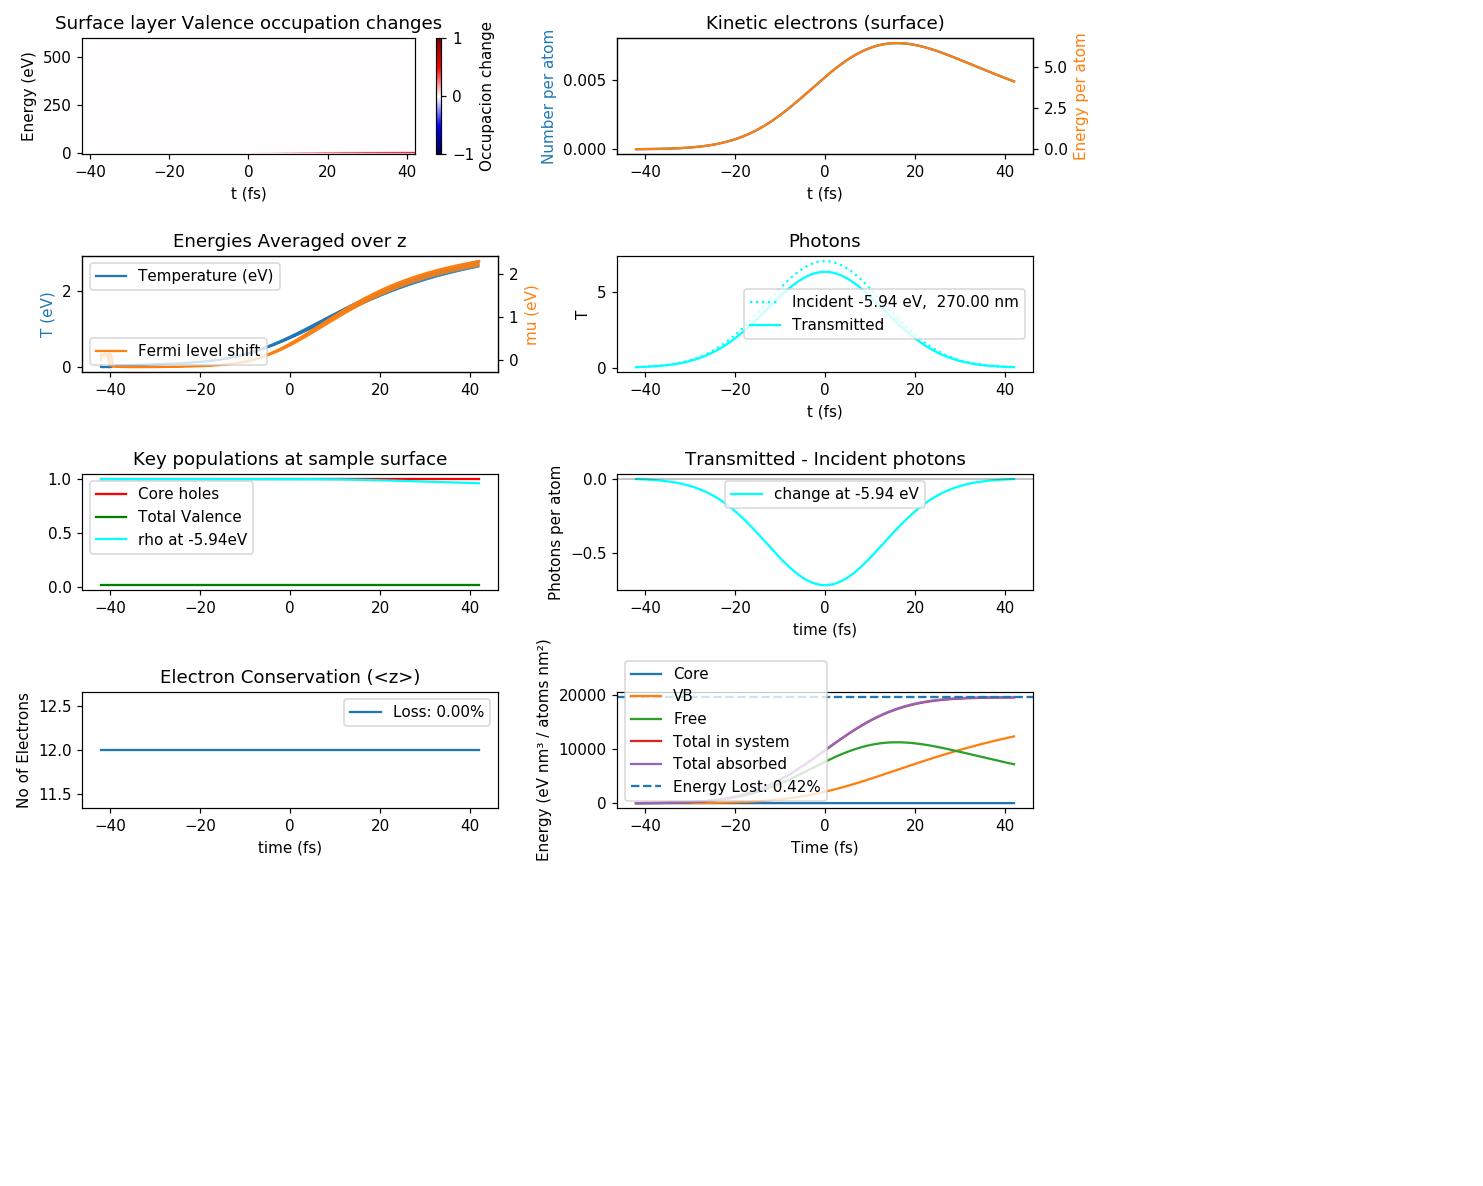

Done
Transmission:  [89.9079828]  %
CPU times: user 10 s, sys: 469 ms, total: 10.5 s
Wall time: 9.89 s


(array([230.57700284]), array([207.30713205]))

In [27]:
%%time

print('Simulating for ', 1.0*np.max(fluences_joules_nm2)* XNLdyn.photons_per_J(PAR.E_i_abs[0])/(PAR.atomic_density*PAR.lambda_res_Ei[0]) ,'photons per atom')

XNLdyn.run_modified_simulation(PAR, dict(t_span=[-42, 42],method='RK45', rtol=1e-3, atol=1e-8, plot = True),
                               ['I0_i',] , [1.0*np.max(fluences_joules_nm2)* XNLdyn.photons_per_J(PAR.E_i_abs[0]),], debug =True)

20

# Load a spectrum to simulate

<IPython.core.display.Javascript object>


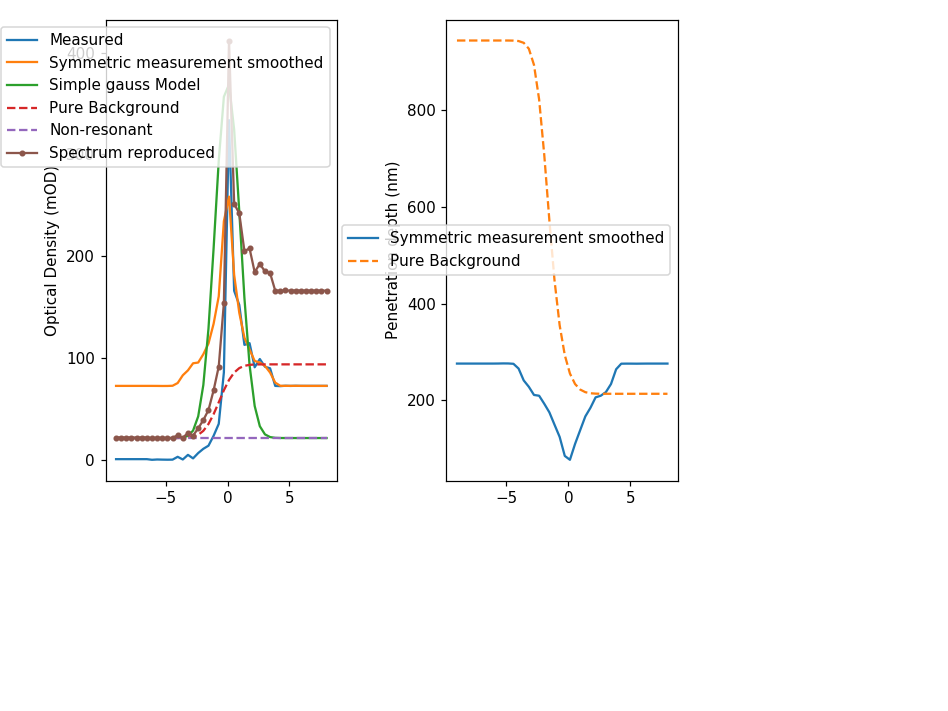

In [28]:
N_points_E = 42# 23
E_fermi = 850.7
Erange = 6

D_samle = PAR.Z


E_min, E_max = E_fermi-1.5*Erange, E_fermi+Erange
enax_abs = np.linspace(E_min, E_max+2, N_points_E) # Absolute energy axis to sample
enax_rel = enax_abs-E_fermi # Rélative energy axis to Fermi Energy, i.e. detuning

dE = enax_abs[1]-enax_abs[0]

ld = np.load('../../Penetration_depth_deconvolved_resonant.npz', allow_pickle=True)
pendepths_res = np.interp(enax_abs, ld['enax'],ld['spectrum'])
pendepths_res_symm = pendepths_res.copy()
pendepths_res_symm[enax_rel<0] = np.interp((E_fermi-enax_abs[enax_rel<0]), ld['enax']-E_fermi,ld['spectrum'])
pendepths_res_symm_sm = sc.ndimage.gaussian_filter(pendepths_res_symm,0.3/dE)

absorption_simple =  350*(np.exp(-(enax_rel**2)/2))

ld = np.load('../../Penetration_depth_deconvolved_background.npz', allow_pickle=True)
pendepths_bkg = np.interp(enax_abs, ld['enax'],ld['spectrum'])
pendepths_nonres = np.full_like(pendepths_bkg, fill_value=pendepths_bkg[0])



plt.figure()
plt.subplot(1,2,1)


plt.plot(enax_rel, 1e3*(D_samle/pendepths_res), ls='-', label = 'Measured')
plt.plot(enax_rel, 1e3*(D_samle/pendepths_res_symm_sm), ls='-', label = 'Symmetric measurement smoothed')
plt.plot(enax_rel, absorption_simple + 1e3*(D_samle/pendepths_nonres), ls='-', label = 'Simple gauss Model')

plt.plot(enax_rel, 1e3*(D_samle/pendepths_bkg), ls='--', label = 'Pure Background')
plt.plot(enax_rel, 1e3*(D_samle/pendepths_nonres), ls='--', label = 'Non-resonant')
plt.plot(enax_rel, 1e3*(D_samle/pendepths_res + D_samle/pendepths_bkg), marker='.',ls='-', label = 'Spectrum reproduced')

#plt.plot(enax_rel, 1e3*(pendepth_res_bkg), ls=':', label = 'Resonant background')

plt.legend()
plt.ylabel('Optical Density (mOD)')


plt.subplot(1,2,2)
#plt.plot(enax_rel, pendepths_res, ls='-', label = 'Measured')
plt.plot(enax_rel, pendepths_res_symm_sm, ls='-', label = 'Symmetric measurement smoothed')
plt.plot(enax_rel, pendepths_bkg, ls='--', label = 'Pure Background')
#plt.plot(enax_rel, pendepths_res + D_samle/pendepths_bkg, ls='--', label = 'Spectrum reproduced')
plt.legend()

plt.ylabel('Penetration depth (nm)')

plt.tight_layout()


pendepths = pendepths_res_symm

## Run it for all the fluences in the spot

TODO: Find solution for low temperature error
      and high temperature Error
TODO: Properly integrate FEG model following PHYSICAL REVIEW E 102, 063204 (2020)

In [29]:
sim_options = dict(t_span=[-42, 42],method='RK45', rtol=1e-3, atol=1e-8, plot = False)

In [30]:
%%time
print(f'I will run {N_points_E*N_local_fluences_to_calculate:.0f} Simulations')

timeout = 1200

progressbar = IntProgress(min=0, max=N_points_E*N_local_fluences_to_calculate) # instantiate the bar
display(progressbar) # display the bar

try:
    mp.set_start_method('fork')  # 'spawn' on windows, "fork" or "forkserver" on unix machines
except RuntimeError:
    pass
with Pool(processes=200) as pool:
    tasklist = {}
    for photon_energy, pendepdth, pendepth_nonres in zip(enax_abs, pendepths, pendepths_nonres):
        for fluence in fluences_simulated_joules_nm2:
            #progressbar.value += 1
            fluence_photons = fluence* XNLdyn.photons_per_J(photon_energy)
            tasklist[(photon_energy,fluence)]=\
                pool.apply_async(XNLdyn.run_modified_simulation,(*(PAR, sim_options,
                                            ['I0_i','E_i_abs', 'lambda_res_Ei','lambda_nonres'] ,
                                            [(fluence_photons,),(photon_energy,),(pendepdth,),pendepth_nonres]),)
                                             )


    resultdict = {}
    for key in tasklist:
        resultdict[key] = tasklist[key].get(timeout=timeout)
        progressbar.value += 1


I will run 1260 Simulations


IntProgress(value=0, max=1260)

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(1.2439254209989451e-05,), (841.7,), (276.0571853276013,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(2.215586200751274e-05,), (841.7,), (276.0571853276013,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(3.94623514407913e-05,), (841.7,), (276.0571853276013,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(7.02873659670056e-05,), (841.7,), (276.0571853276013,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.00012519055844890914,), (841.7,), (276.0571853276013,), 943.1320479470685]



Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [

Energy -9.00 too close to others to satisfy the resonant bandwidth of 0.60

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.0012593165847878452,), (842.1146341463415,), (276.0571853276013,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.012673954873191475,), (842.1146341463415,), (276.0571853276013,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.003995062148035092,), (842.1146341463415,), (276.0571853276013,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.007115703575880052,), (842.1146341463415,), (276.0571853276013,), 943.1320479470685]


Energy -9.00 too close to others to satisfy the resonant bandwidth of 0.60
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] 

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.7203748349115349,), (842.529268292683,), (276.0571853276013,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(4.070440944456865,), (842.529268292683,), (276.0571853276013,), 943.1320479470685]




Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(12.913086938937916,), (842.529268292683,), (276.0571853276013,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(7.249962606495572,), (842.529268292683,), (276.0571853276013,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.07157828680507694,), (842.529268292683,), (276.0571853276013,), 943.1320479470685]

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_r


Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(1.2414791354268009e-05,), (843.3585365853659,), (276.0571853276013,), 943.1320479470685]

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(3.938474535658171e-05,), (843.3585365853659,), (276.0571853276013,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(7.014913985926112e-05,), (843.3585365853659,), (276.0571853276013,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.00012494436052439345,), (843.3585365853659,), (276.0571853276013,), 943.1320479470685]



Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.00022254147746030595,), (843.3585365853659,), (276.0571853276013,), 943.1320479470685]

Initializing a simulation where ['I0

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.07147276507408754,), (843.7731707317074,), (276.0571853276013,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.0007056447536213963,), (843.7731707317074,), (276.0571853276013,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.22674055262362458,), (843.7731707317074,), (276.0571853276013,), 943.1320479470685]

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.40385318208240617,), (843.7731707317074,), (276.0571853276013,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.7193128480586213,), (843.7731707317074,), (276.0571853276013,), 943.1320479470685]


Initializing a simulation where ['I0_i', 'E_i_abs',


Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(40.88505763249319,), (844.1878048780488,), (276.0571853276013,), 943.1320479470685]

Transmission:  [97.89768591]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(72.82138300118368,), (844.1878048780488,), (276.0571853276013,), 943.1320479470685]

Transmission:  [97.89950046]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(129.7039585922111,), (844.1878048780488,), (276.0571853276013,), 943.1320479470685]

Transmission:  [97.897686]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(231.01891479068127,), (844.1878048780488,), (276.0571853276013,), 943.1320479470685]

Transmission:  [97.897686]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(1.2396507261620359e

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(7.001145635133864e-05,), (845.0170731707318,), (276.0571853276013,), 943.1320479470685]

Transmission:  [97.8818878]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.00012469912903778302,), (845.0170731707318,), (276.0571853276013,), 943.1320479470685]

Transmission:  [97.88187185]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.00022210468962033443,), (845.0170731707318,), (276.0571853276013,), 943.1320479470685]

Transmission:  [97.85993934]  %
Transmission:  [97.88188497]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.0003955961323226105,), (845.0170731707318,), (276.0571853276013,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0


Transmission:  [97.88188779]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.003979387418365078,), (845.4317073170732,), (276.5531649119428,), 943.1320479470685]

Transmission:  [97.88188781]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.007087784928852564,), (845.4317073170732,), (276.5531649119428,), 943.1320479470685]

Transmission:  [97.85994824]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.012624228283434935,), (845.4317073170732,), (276.5531649119428,), 943.1320479470685]
Transmission:  [97.88188781]  %

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.022485323884972763,), (845.4317073170732,), (276.5531649119428,), 943.1320479470685]

Transmission:  [97.897686]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_


Transmission:  [97.89782032]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.2261848111675852,), (845.8463414634147,), (276.31956137758095,), 943.1320479470685]

Transmission:  [97.88161025]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.40286333728914075,), (845.8463414634147,), (276.31956137758095,), 943.1320479470685]

Transmission:  [97.92534007]  %
Transmission:  [97.89741193]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.7175498111210185,), (845.8463414634147,), (276.31956137758095,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(1.2780456392592363,), (845.8463414634147,), (276.31956137758095,), 943.1320479470685]
Transmission:  [97.89752979]  %


Transmission:  [97.85994824]  %
Initializing a simulation where ['I0_i', 'E_i_




Transmission:  [97.85994824]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(12.856144857942965,), (846.2609756097561,), (276.00972038099025,), 943.1320479470685]
Transmission:  [97.89778621]  %
Transmission:  [97.92549649]  %
Transmission:  [97.92550161]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(22.898396207100294,), (846.2609756097561,), (276.00972038099025,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(40.78489738962393,), (846.2609756097561,), (276.00972038099025,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(72.64298512602264,), (846.2609756097561,), (276.00972038099025,), 943.1320479470685]




Transmission:  [97.89782082]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_no



Transmission:  [97.89778622]  %
Transmission:  [97.89778622]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(2.20148787994674e-05,), (847.090243902439,), (228.79829552985618,), 943.1320479470685]

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(3.921124277703229e-05,), (847.090243902439,), (228.79829552985618,), 943.1320479470685]
Transmission:  [97.89781797]  %

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(6.984011014208101e-05,), (847.090243902439,), (228.79829552985618,), 943.1320479470685]

Transmission:  [97.89779864]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.0001243939400848333,), (847.090243902439,), (228.79829552985618,), 943.1320479470685]

Transmission:  [97.89782082]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'l

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.0012513071635818919,), (847.5048780487805,), (239.28943932805743,), 943.1320479470685]
Transmission:  [97.89779813]  %

Transmission:  [97.88537597]  %

Transmission:  [97.88538102]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.002228734004251536,), (847.5048780487805,), (239.28943932805743,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.00707044675340635,), (847.5048780487805,), (239.28943932805743,), 943.1320479470685]

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.003969653020676569,), (847.5048780487805,), (239.28943932805743,), 943.1320479470685]

Transmission:  [97.88529112]  %

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(


Transmission:  [97.89779863]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.07112326198438461,), (847.919512195122,), (195.6823207167966,), 943.1320479470685]

Transmission:  [97.88538102]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.126679393430576,), (847.919512195122,), (195.6823207167966,), 943.1320479470685]

Transmission:  [97.89763366]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.2256317872971291,), (847.919512195122,), (195.6823207167966,), 943.1320479470685]

Transmission:  [97.88538102]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.4018783328544821,), (847.919512195122,), (195.6823207167966,), 943.1320479470685]

Transmission:  [97.89774778]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] a

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(4.042588224642114,), (848.3341463414635,), (224.1725967704422,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(7.2003534413211865,), (848.3341463414635,), (224.1725967704422,), 943.1320479470685]

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(12.824726833150471,), (848.3341463414635,), (224.1725967704422,), 943.1320479470685]



Transmission:  [97.89779616]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(22.84243678942941,), (848.3341463414635,), (224.1725967704422,), 943.1320479470685]

Transmission:  [97.89779615]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(40.685226692731085,), (848.3341463414635,), (224.1725967704422,), 943.13204794

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(129.00696013374161,), (848.7487804878049,), (185.81063486691153,), 943.1320479470685]

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(1.23299238852148e-05,), (849.1634146341464,), (183.74657244997317,), 943.1320479470685]


Transmission:  [97.89777256]  %
Transmission:  [97.89777256]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(2.1961131073643857e-05,), (849.1634146341464,), (183.74657244997317,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(3.911551137895477e-05,), (849.1634146341464,), (183.74657244997317,), 943.1320479470685]


Transmission:  [97.89777255]  %
Transmission:  [97.89777256]  %
Transmission:  [97.89684557]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', '


Transmission:  [97.89777167]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.00039347236710359716,), (849.5780487804878,), (142.2998680143369,), 943.1320479470685]

Transmission:  [97.90065288]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.0007008233228577204,), (849.5780487804878,), (142.2998680143369,), 943.1320479470685]

Transmission:  [97.93683147]  %
Transmission:  [97.90065285]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.0012482536791002276,), (849.5780487804878,), (142.2998680143369,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.0022232953678449014,), (849.5780487804878,), (142.2998680143369,), 943.1320479470685]


Transmission:  [97.90065288]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', '


Transmission:  [97.89776531]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.022364669888912832,), (849.9926829268293,), (137.8137252905014,), 943.1320479470685]

Transmission:  [97.8977653]  %
Transmission:  [97.89774505]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.03983426430054027,), (849.9926829268293,), (137.8137252905014,), 943.1320479470685]

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.07094978912038084,), (849.9926829268293,), (137.8137252905014,), 943.1320479470685]

Transmission:  [97.89909528]  %
Transmission:  [97.89772923]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.12637041664048604,), (849.9926829268293,), (137.8137252905014,), 943.1320479470685]

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_no

Transmission:  [97.90210071]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(1.271191118053,), (850.4073170731708,), (72.9228965516095,), 943.1320479470685]

Transmission:  [97.90210071]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(2.2641498052303244,), (850.4073170731708,), (72.9228965516095,), 943.1320479470685]

Transmission:  [97.89911697]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(4.0327329759637305,), (850.4073170731708,), (72.9228965516095,), 943.1320479470685]
Transmission:  [97.90210068]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(7.1828000152007805,), (850.4073170731708,), (72.9228965516095,), 943.1320479470685]


Transmission:  [97.90210044]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are ch

Transmission:  [97.89779376]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(72.25357006344136,), (850.8219512195122,), (59.9612517234269,), 943.1320479470685]
Transmission:  [97.8977937]  %

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(128.69261298560744,), (850.8219512195122,), (59.9612517234269,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(229.21758222495387,), (850.8219512195122,), (59.9612517234269,), 943.1320479470685]
Transmission:  [97.89779253]  %


Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(1.2299894586941607e-05,), (851.2365853658537,), (120.5573004826708,), 943.1320479470685]

Transmission:  [97.89778122]  %
Transmission:  [97.89333973]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres']


Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.00012372775454581257,), (851.6512195121952,), (131.57665581157886,), 943.1320479470685]

Transmission:  [97.97109076]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.0002203745505912251,), (851.6512195121952,), (131.57665581157886,), 943.1320479470685]

Transmission:  [97.9530344]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.0003925145390907611,), (851.6512195121952,), (131.57665581157886,), 943.1320479470685]
Transmission:  [97.97099541]  %

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.0006991173117961983,), (851.6512195121952,), (131.57665581157886,), 943.1320479470685]

Transmission:  [97.89780246]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed t


Transmission:  [97.89780245]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.007032599754780713,), (852.0658536585366,), (177.42143471816695,), 943.1320479470685]

Transmission:  [97.97109104]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.012525936610883165,), (852.0658536585366,), (177.42143471816695,), 943.1320479470685]

Transmission:  [97.89780245]  %
Transmission:  [97.89778533]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.022310254166420365,), (852.0658536585366,), (177.42143471816695,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.039737343117145364,), (852.0658536585366,), (177.42143471816695,), 943.1320479470685]


Transmission:  [97.97109105]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'l

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.7119657179688995,), (852.4804878048781,), (174.73830057157048,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.3997281871321342,), (852.4804878048781,), (174.73830057157048,), 943.1320479470685]



Transmission:  [97.89548611]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(1.2680996734298629,), (852.4804878048781,), (174.73830057157048,), 943.1320479470685]

Transmission:  [97.89548613]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(2.25864355708089,), (852.4804878048781,), (174.73830057157048,), 943.1320479470685]

Transmission:  [97.85961206]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(4.022925661785681,), (852.4804878048781,),

Transmission:  [97.89724043]  %

Transmission:  [97.8933062]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(40.467656769012414,), (852.8951219512196,), (220.4000828086536,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(72.07794004415575,), (852.8951219512196,), (220.4000828086536,), 943.1320479470685]


Transmission:  [97.89712808]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(128.379794033122,), (852.8951219512196,), (220.4000828086536,), 943.1320479470685]
Transmission:  [97.90079575]  %

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(228.66041268507615,), (852.8951219512196,), (220.4000828086536,), 943.1320479470685]

Transmission:  [97.90084477]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] a



Transmission:  [69.53997469]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(6.92973945813201e-05,), (853.7243902439025,), (219.13087099918727,), 943.1320479470685]
Transmission:  [69.55426559]  %

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.00012342729603442932,), (853.7243902439025,), (219.13087099918727,), 943.1320479470685]
Transmission:  [78.9868214]  %

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.0002198393965373877,), (853.7243902439025,), (219.13087099918727,), 943.1320479470685]

Transmission:  [69.53404212]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.0003915613630265513,), (853.7243902439025,), (219.13087099918727,), 943.1320479470685]

Transmission:  [69.53350163]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'


Transmission:  [88.22032708]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.003938820500077476,), (854.139024390244,), (222.92074365278603,), 943.1320479470685]
Transmission:  [85.32207228]  %

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.0070155301916731945,), (854.139024390244,), (222.92074365278603,), 943.1320479470685]
Transmission:  [83.13037842]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.012495533591670405,), (854.139024390244,), (222.92074365278603,), 943.1320479470685]


Transmission:  [83.86673689]  %
Transmission:  [82.8316747]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.022256102600183483,), (854.139024390244,), (222.92074365278603,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.12569594478920518,), (854.5536585365854,), (276.157521141103,), 943.1320479470685]
Transmission:  [87.31689101]  %

Transmission:  [87.31771259]  %

Transmission:  [83.86667148]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.39875843553149165,), (854.5536585365854,), (276.157521141103,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.7102384695115003,), (854.5536585365854,), (276.157521141103,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(1.2650232286664707,), (854.5536585365854,), (276.157521141103,), 943.1320479470685]



Transmission:  [87.4235676]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(2.2531640255510

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(12.72521306716808,), (854.9682926829269,), (276.9617710279899,), 943.1320479470685]

Transmission:  [88.57224562]  %
Transmission:  [88.57224546]  %
Transmission:  [88.57224601]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(22.665190370171956,), (854.9682926829269,), (276.9617710279899,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(40.369528730449694,), (854.9682926829269,), (276.9617710279899,), 943.1320479470685]

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(71.90316177813096,), (854.9682926829269,), (276.9617710279899,), 943.1320479470685]

Transmission:  [89.31239732]  %

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(128.06849215934

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(2.1790888291927438e-05,), (855.7975609756098,), (276.19377940636224,), 943.1320479470685]

Transmission:  [89.30736107]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(3.8812287767972124e-05,), (855.7975609756098,), (276.19377940636224,), 943.1320479470685]
Transmission:  [88.57226366]  %

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(6.912952155061668e-05,), (855.7975609756098,), (276.19377940636224,), 943.1320479470685]
Transmission:  [89.30711807]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.0001231282932453344,), (855.7975609756098,), (276.19377940636224,), 943.1320479470685]


Transmission:  [88.57225071]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed 

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.0012385818972386745,), (856.2121951219513,), (275.6328265110214,), 943.1320479470685]


Transmission:  [88.57230278]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.0022060687189900813,), (856.2121951219513,), (275.6328265110214,), 943.1320479470685]

Transmission:  [88.57296779]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.003929283322932918,), (856.2121951219513,), (275.6328265110214,), 943.1320479470685]

Transmission:  [88.57352978]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.006998543290594644,), (856.2121951219513,), (275.6328265110214,), 943.1320479470685]

Transmission:  [88.57453555]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.

Transmission:  [89.40690811]  %

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.0704003184899517,), (856.6268292682927,), (276.0571853276013,), 943.1320479470685]
Transmission:  [89.25335595]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.12539174096914288,), (856.6268292682927,), (276.0571853276013,), 943.1320479470685]

Transmission:  [89.40123863]  %
Transmission:  [89.40138517]  %
Transmission:  [89.40130708]  %

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.3977933778315462,), (856.6268292682927,), (276.0571853276013,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.7085195814762266,), (856.6268292682927,), (276.0571853276013,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(4.001516585788164,), (857.0414634146342,), (276.0571853276013,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(7.127199733911643,), (857.0414634146342,), (276.0571853276013,), 943.1320479470685]



Transmission:  [89.40120713]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(12.694430963370575,), (857.0414634146342,), (276.0571853276013,), 943.1320479470685]

Transmission:  [91.02049454]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(22.6103636070457,), (857.0414634146342,), (276.0571853276013,), 943.1320479470685]

Transmission:  [91.01295648]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(40.271875432459495,), (857.0414634146342,), (276


Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(227.4441235151234,), (857.4560975609756,), (276.0571853276013,), 943.1320479470685]
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(1.220477617613868e-05,), (857.8707317073171,), (276.0571853276013,), 943.1320479470685]


Transmission:  [91.04158543]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(2.1738227407070328e-05,), (857.8707317073171,), (276.0571853276013,), 943.1320479470685]

Transmission:  [91.00959649]  %
Transmission:  [90.9744435]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(3.8718492169104893e-05,), (857.8707317073171,), (276.0571853276013,), 943.1320479470685]
Transmission:  [91.00961665]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(6.89


Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.00038948058442127867,), (858.2853658536586,), (276.0571853276013,), 943.1320479470685]

Transmission:  [91.02162385]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.0006937134604189896,), (858.2853658536586,), (276.0571853276013,), 943.1320479470685]

Transmission:  [90.97444286]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.0012355901280202588,), (858.2853658536586,), (276.0571853276013,), 943.1320479470685]
Transmission:  [91.01289067]  %

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.002200740005158643,), (858.2853658536586,), (276.0571853276013,), 943.1320479470685]

Transmission:  [90.97444321]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.022137889555898325,), (858.7,), (276.0571853276013,), 943.1320479470685]


Transmission:  [91.02162044]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.07023035007281388,), (858.7,), (276.0571853276013,), 943.1320479470685]

Transmission:  [91.04622621]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.1250890060356678,), (858.7,), (276.0571853276013,), 943.1320479470685]

Transmission:  [91.02790546]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.2227991091425355,), (858.7,), (276.0571853276013,), 943.1320479470685]

Transmission:  [90.97742226]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.3968329800346586,), (858.7,), (276.0571853276013,), 943

Transmission:  [90.98793907]  %
Transmission:  [90.98103198]  %
Transmission:  [90.981032]  %
Transmission:  [90.9810422]  %
Transmission:  [90.98103198]  %
Transmission:  [90.98431569]  %
Transmission:  [90.98103298]  %
Transmission:  [90.98776779]  %
Transmission:  [90.98103215]  %
Transmission:  [91.04920291]  %
Transmission:  [90.98103197]  %
Transmission:  [90.99805781]  %
Transmission:  [90.98776336]  %
Transmission:  [90.98103207]  %
Transmission:  [90.98103254]  %
Transmission:  [90.98161378]  %
Transmission:  [90.98775773]  %
Transmission:  [90.98775769]  %
Transmission:  [90.98287497]  %
Transmission:  [90.98775785]  %
Transmission:  [90.99960064]  %
Transmission:  [90.98121538]  %
Transmission:  [90.98103197]  %
Transmission:  [90.98775947]  %
Transmission:  [90.98103202]  %
Transmission:  [90.98206817]  %
Transmission:  [90.98878251]  %
Transmission:  [90.98808076]  %
Transmission:  [90.98778978]  %
Transmission:  [90.98776086]  %
Transmission:  [90.98775824]  %
Transmissio

## Assemble the results into a Matrix

In [31]:
fl_dep_spectrum_I = np.zeros((N_points_E,N_local_fluences_to_calculate))
fl_dep_spectrum_T = np.zeros((N_points_E,N_local_fluences_to_calculate))

for i_photen in range(N_points_E):
    for i_pulseen in range(N_local_fluences_to_calculate):
        fl_dep_spectrum_I[i_photen, i_pulseen], fl_dep_spectrum_T[i_photen, i_pulseen]  = \
            resultdict[(enax_abs[i_photen],fluences_simulated_joules_nm2[i_pulseen])]


<IPython.core.display.Javascript object>


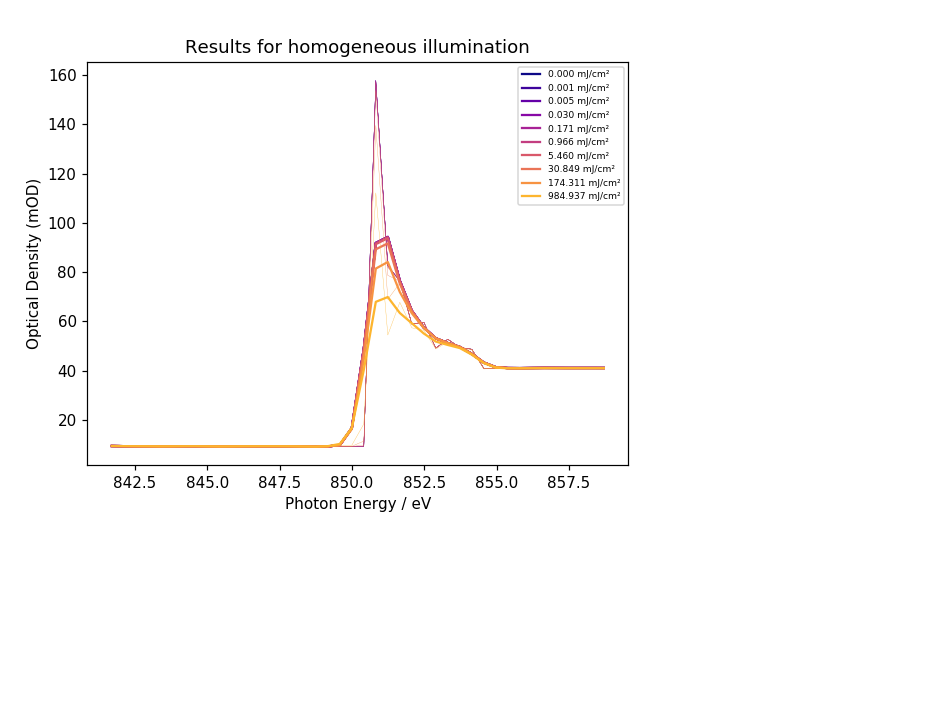

<IPython.core.display.Javascript object>


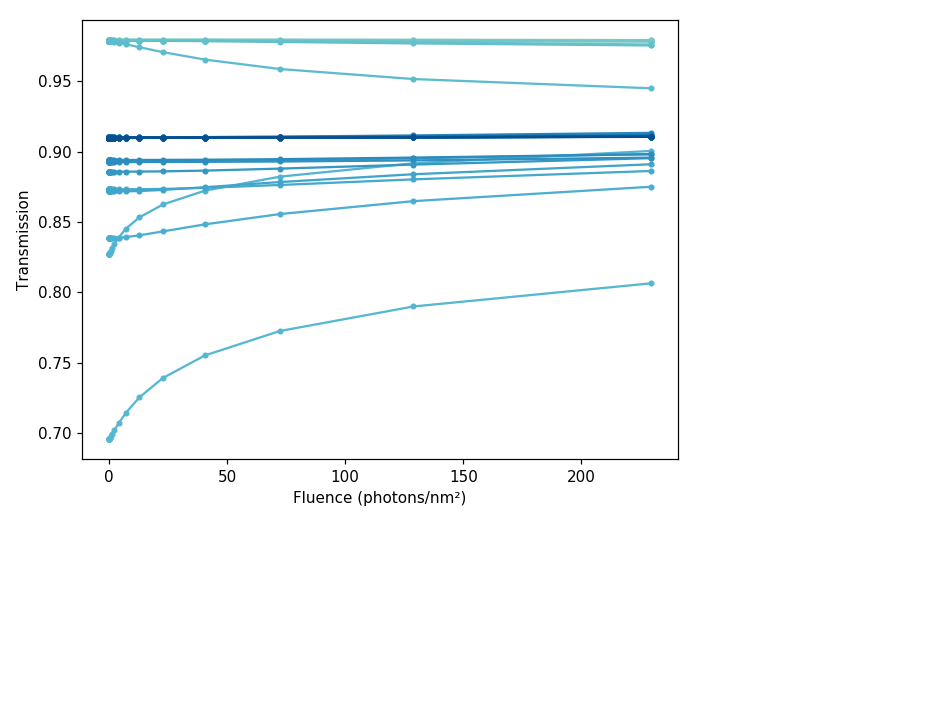

In [43]:
T = fl_dep_spectrum_T/fl_dep_spectrum_I
import matplotlib as mpl
plotcols =  mpl.cm.plasma(np.linspace(.0,0.9,N_local_fluences_to_calculate))#YlOrRd_r

#fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,4))
plt.figure()


dE = np.mean(enax_rel[1:]-enax_rel[:-1])
aufl = 0.4

for i in range(N_local_fluences_to_calculate):
    if np.mod(i,3)==0:
        spec = 1e3*np.log10(1/T[:,i])
        spec_sm = sc.ndimage.gaussian_filter(spec,aufl/dE)
        plt.plot(enax_abs,spec, color = plotcols[i], lw=0.2)
        plt.plot(enax_abs,spec_sm, color = plotcols[i], label = f'{fluences_simulated_joules_nm2[i]*1e17:.3f} mJ/cm²')
plt.legend(fontsize = 6)


plt.title('Results for homogeneous illumination')
plt.ylabel('Optical Density (mOD)')
plt.xlabel('Photon Energy / eV')

plt.figure()

plt.xlabel('Fluence (photons/nm²)')
plt.ylabel('Transmission')
plotcols2 =  mpl.cm.GnBu(np.linspace(.2,0.95,N_points_E))#YlOrRd_r

for i in range(N_points_E):
    plt.plot(fluences_simulated_joules_nm2*XNLdyn.photons_per_J(850), T[i,:], '.-', color = plotcols2[i])#, label ='For one z-stack'

#plt.xscale('log')
#plt.legend(loc = 'lower right')
plt.tight_layout()




In [14]:
pulse_energy_max

5e-07

<IPython.core.display.Javascript object>


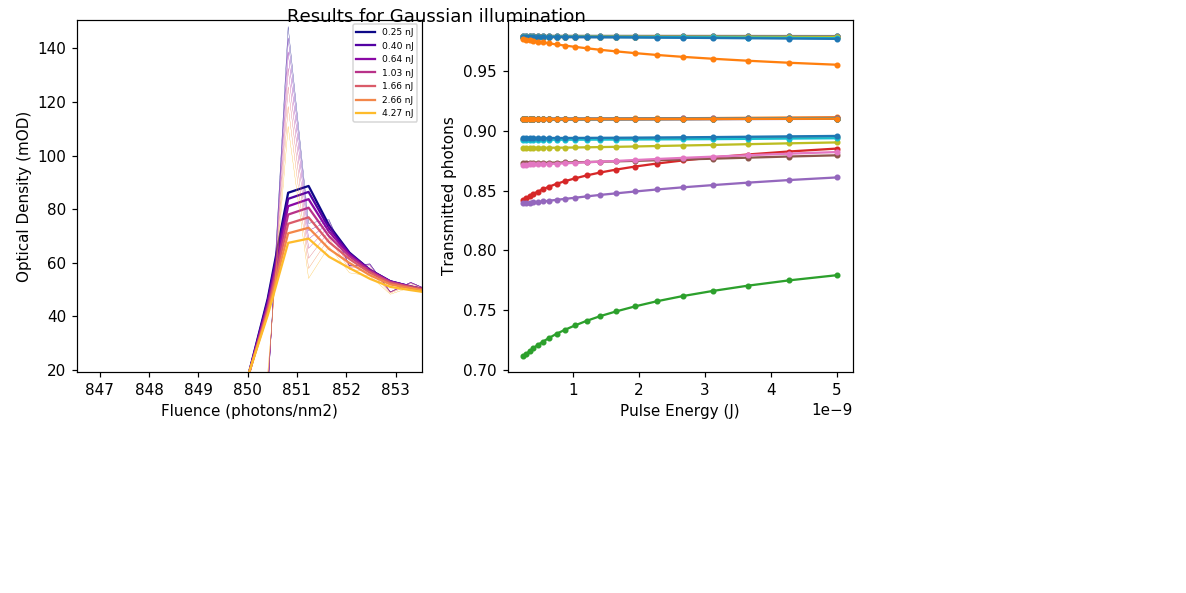

In [38]:
# These are the pulse energies for which we evaluate stuff
final_pulse_energies = np.logspace(np.log10(1/N_pulse_energies), np.log10(1), N_pulse_energies)* pulse_energy_max

final_transmissions = np.zeros((N_points_E, N_pulse_energies))
final_incidence_check = np.zeros((N_points_E, N_pulse_energies))
for i_photen in range(N_points_E):

    for ipe, pulse_en in enumerate(final_pulse_energies*XNLdyn.photons_per_J(enax_abs[i_photen])):
        local_fluences, dA = XNLdyn.calculate_fluences(Nsteps_r, pulse_en, pulse_profile_sigma)
        
        
        local_transmitted = np.interp(local_fluences, fluences_simulated_joules_nm2*XNLdyn.photons_per_J(enax_abs[i_photen]),
                                      fl_dep_spectrum_T[i_photen,:])# tr[:, 0]
        final_transmissions[i_photen,ipe] = np.sum(local_transmitted*dA)

        
        local_incidence_check = np.interp(local_fluences, fluences_simulated_joules_nm2*XNLdyn.photons_per_J(enax_abs[i_photen]),
                                          fl_dep_spectrum_I[i_photen,:])

        final_incidence_check[i_photen,ipe] = np.sum(local_incidence_check*dA) # should result equal final_pulse_energies

        
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,4))
fig.suptitle('Results for Gaussian illumination')

plt.sca(ax1)

plotcols =  mpl.cm.plasma(np.linspace(.0,0.9,N_pulse_energies))#YlOrRd_r
for i in range(N_pulse_energies):
    if np.mod(i,3)==0:
        spec = 1e3*np.log10(final_incidence_check[:,i]/final_transmissions[:,i])
        spec_sm = sc.ndimage.gaussian_filter(spec,aufl/dE)
        ax1.plot(enax_abs, spec, color = plotcols[i], lw=0.2)#, label ='For one z-stack'

        ax1.plot(enax_abs, spec_sm, color = plotcols[i], label = f'{final_pulse_energies[i]*1e9:.2f} nJ')#, label ='For one z-stack'
plt.xlabel('Fluence (photons/nm2)')
plt.ylabel('Optical Density (mOD)')
ax1.legend(fontsize = 6)

plt.sca(ax2)
plt.plot(final_pulse_energies, (final_transmissions/final_incidence_check).T, '.-')

plt.xlabel('Pulse Energy (J)')
plt.ylabel('Transmitted photons')
#plt.legend(loc = 'lower left')
plt.tight_layout()

<IPython.core.display.Javascript object>


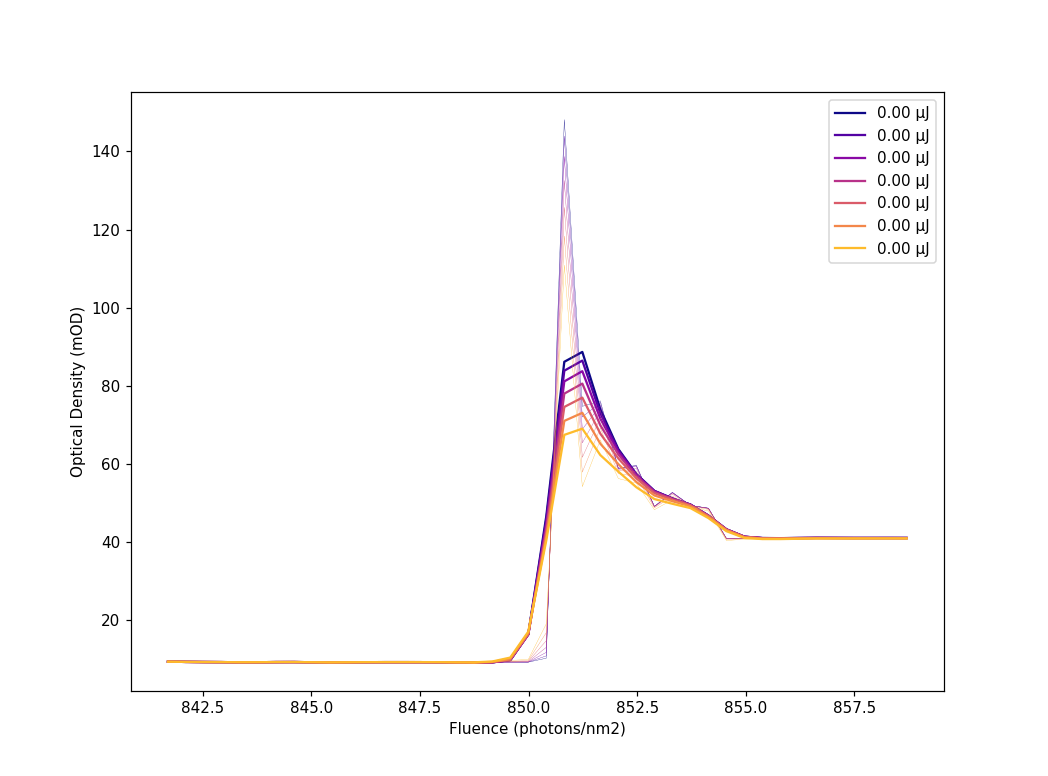

In [42]:
plt.figure()
for i in range(N_pulse_energies):
    if np.mod(i,3)==0:
        spec = 1e3*np.log10(final_incidence_check[:,i]/final_transmissions[:,i])
        spec_sm = sc.ndimage.gaussian_filter(spec,aufl/dE)
        plt.plot(enax_abs, spec, color = plotcols[i], lw=0.2)#, label ='For one z-stack'

        plt.plot(enax_abs, spec_sm, color = plotcols[i], label = f'{final_pulse_energies[i]*1e6:.2f} µJ')#, label ='For one z-stack'
plt.xlabel('Fluence (photons/nm2)')
plt.ylabel('Optical Density (mOD)')
plt.legend()

In [22]:
final_pulse_energies

array([2.50000000e-08, 2.92694978e-08, 3.42681402e-08, 4.01204502e-08,
       4.69722172e-08, 5.49941284e-08, 6.43860209e-08, 7.53818600e-08,
       8.82555675e-08, 1.03327846e-07, 1.20974166e-07, 1.41634124e-07,
       1.65822388e-07, 1.94141521e-07, 2.27296993e-07, 2.66114753e-07,
       3.11561808e-07, 3.64770307e-07, 4.27065748e-07, 5.00000000e-07])

<IPython.core.display.Javascript object>


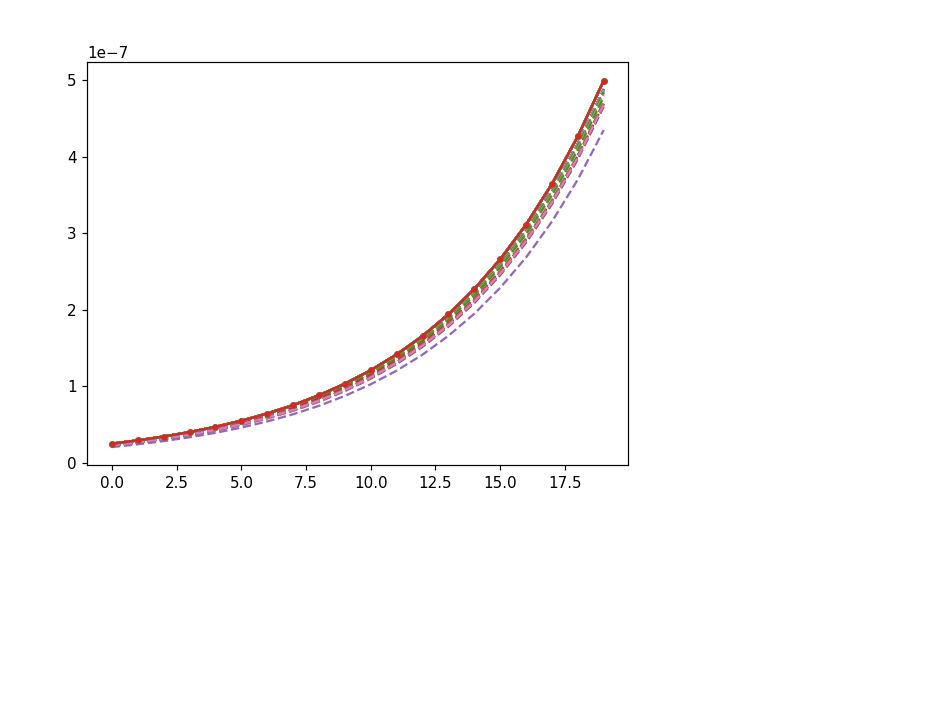

In [26]:
plt.figure()
plt.plot((1/XNLdyn.photons_per_J(enax_abs))*final_transmissions.T,'--')
plt.plot((1/XNLdyn.photons_per_J(enax_abs))*final_incidence_check.T,'.-')
#plt.plot(final_pulse_energies,'x')